<a href="https://colab.research.google.com/github/radwahashiesh/DeepLearningBreastCancer/blob/main/CNN_maskimg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
import numpy as np 
import pandas as pd
import os
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras import backend as K
# Common imports
import numpy as np
import os
import timeit
 

In [227]:
import warnings
warnings.filterwarnings("ignore")

In [228]:
path = "/content/drive/MyDrive/Dataset_BUSI_with_GT (2)"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict 

{'benign': 891, 'malignant': 421, 'normal': 266}

In [229]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [230]:
df = pd.DataFrame(os.listdir(dir_list[0]))
# df = df.apply(str,axis=1)
df = df[0].apply(clean)
# print(df.info())
df = df[~df.str.contains('mask',regex =False)]
df = df.apply(str)
df_list = list(df)
type(df_list)
df_list.sort()
print(len(df_list))

210


In [231]:
img_size = 128
img_channel = 3
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,1) 
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,0) 
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,2)

In [232]:
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):
    
    val = 0
    
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    
    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale ans resize it
        
        if image[-5] == ')' :                                   #if real image 
            
            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image
            
            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


In [233]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)
X /= 255.0
Xm /= 255.0

print(X.shape)
print(Xm.shape)
print(y.shape)


(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)


In [234]:
masks=[]
for i  in (Xm):
   img1 =  np.expand_dims(i, axis=-1)
   masks.append(img1)

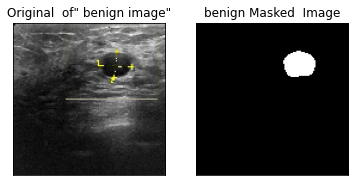

In [235]:
plt.subplot(121),plt.imshow(X[5],cmap = 'gray')

plt.title('Original  of" benign image"'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(Xm[5],cmap = 'gray')
plt.title('benign Masked  Image'), plt.xticks([]), plt.yticks([])

plt.show()

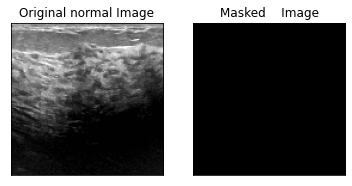

In [236]:
plt.subplot(121),plt.imshow(X[500],cmap = 'gray')
plt.title('Original normal Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(Xm[500],cmap = 'gray')
plt.title('Masked    Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [237]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(Xm,y, test_size=.2, stratify=y, random_state=42)

In [238]:

#one-hot encode target column
y_train1 = tensorflow.keras.utils.to_categorical(y_train, num_classes=3)
y_test1 = tensorflow.keras.utils.to_categorical(y_test, num_classes=3)



initializing CNN & add a convolutional layer 

In [239]:
start = timeit.default_timer()

In [240]:
def build_model():
   model=Sequential()
   model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(128,128,3)))
   model.add(MaxPooling2D(pool_size=2))
   model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
   model.add(MaxPooling2D(pool_size=2))
   model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
   model.add(MaxPooling2D(pool_size=2))
   model.add(Flatten())
   model.add(BatchNormalization())
   model.add(Dense(512,activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(256,activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(128,activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(3,activation='softmax'))
   model.compile(loss='binary_crossentropy',optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['accuracy'])
   return model



In [241]:
model = build_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 128, 128, 16)      208       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 16, 16, 64)     

In [242]:
history=model.fit(X_train, y_train1,batch_size=32, epochs=50, verbose=1,validation_data=(X_test, y_test1))

Epoch 1/50
20/20 [==============================] - 1s 31ms/step - loss: 0.8161 - accuracy: 0.3734 - val_loss: 0.6847 - val_accuracy: 0.5064
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 0.6453 - accuracy: 0.5337 - val_loss: 0.6742 - val_accuracy: 0.6026
Epoch 3/50
20/20 [==============================] - 0s 16ms/step - loss: 0.5718 - accuracy: 0.5913 - val_loss: 0.6654 - val_accuracy: 0.5513
Epoch 4/50
20/20 [==============================] - 0s 17ms/step - loss: 0.5143 - accuracy: 0.6490 - val_loss: 0.6560 - val_accuracy: 0.5577
Epoch 5/50
20/20 [==============================] - 0s 16ms/step - loss: 0.4846 - accuracy: 0.6987 - val_loss: 0.6470 - val_accuracy: 0.5577
Epoch 6/50
20/20 [==============================] - 0s 18ms/step - loss: 0.4663 - accuracy: 0.7276 - val_loss: 0.6388 - val_accuracy: 0.5897
Epoch 7/50
20/20 [==============================] - 0s 18ms/step - loss: 0.4344 - accuracy: 0.7356 - val_loss: 0.6282 - val_accuracy: 0.7436
Epoch 8/50
20

In [243]:
end = timeit.default_timer()

Plotting loss graph

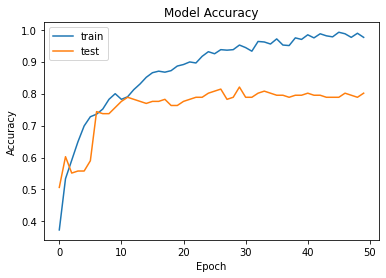

In [244]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    



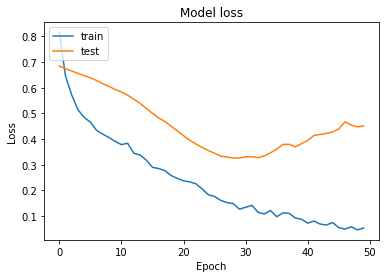

In [245]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [246]:
from sklearn.metrics import accuracy_score,classification_report
y_predictt = model.predict(X_test)
y_predictt = y_predictt.argmax(axis=-1)
score=accuracy_score(y_test, y_predictt)*100
print(' test accuracy is   : \n{0}'.format(score))
pred = model.predict_generator(X_test)
y_predict = pred.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_predict)
print('Confusion matrix of testing: \n{0}'.format(conf_mx))
print('classification_report is')
print(classification_report(y_test, y_predict))
print('time to CNN model in seconds is : \n{0}'.format(end-start))

 test accuracy is   : 
80.12820512820514
Confusion matrix of testing: 
[[27  0  0]
 [ 0 72 15]
 [ 0 16 26]]
classification_report is
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      0.83      0.82        87
           2       0.63      0.62      0.63        42

    accuracy                           0.80       156
   macro avg       0.82      0.82      0.82       156
weighted avg       0.80      0.80      0.80       156

time to CNN model in seconds is : 
21.60511111300002
